## Assignment 1


In [1]:
import time
import torch
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import deepwave
%matplotlib inline

## setting the parameters 

In [21]:
device = torch.device('cuda:0')


# Load the true model for forward modelling 
path = './'
velocity_file= path + 'Marm.bin' # true model 

par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':221,   'dz':0.015, 'oz':0,
       'ns':50,    'ds':0.16,   'osou':0,  'sz':0,
       'nr':601,   'dr':0.015,  'orec':0, 'rz':0,
       'nt':4000,  'dt':0.001,  'ot':0,
       'freq':15,
       'num_batches':10,
        'FWI_itr': 100
      }

# Mapping the par dictionary to variables 
for k in par:
    locals()[k] = par[k]
    
fs = 1/dt # sampling frequency


# Don't change the below two lines 
num_sources_per_shot=1
num_dims = 2 



## The aquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [22]:

x_s = torch.zeros(ns, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(ns).float() * ds  
x_s[:, 0, 0] = sz

x_r = torch.zeros(ns, nr, num_dims)
x_r[0, :, 1] = torch.arange(nr).float() * dr
x_r[:, :, 1] = x_r[0, :, 1].repeat(ns, 1)
x_r[:, :, 0] = rz





In [23]:
rz

0

## Create true source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use whatever Tensor you want as the source wavelet. 

torch.Size([4000, 50, 1])


Text(0.5, 0, 'Time (s)')

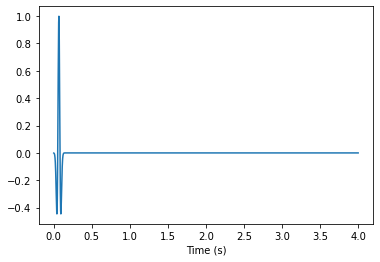

In [24]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, ns, num_sources_per_shot))
print(source_wavelet.shape)


plt.plot(np.arange(0,nt)*dt,source_wavelet[:,0,0])
plt.xlabel('Time (s)')

### Load the velocity model 
Note: We often do not update the water layer, thus we will keep it untouched by masking the gradient in this region. 

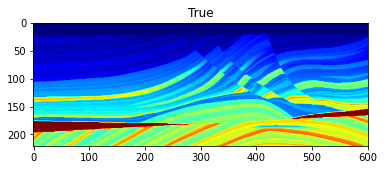

In [25]:
# function to get water layer mask
def mask(m):
    water_velocity= 1.5 # km/s
    msk = np.ones_like(m) 
    for i in range(m.shape[0]):
        for j in range (m.shape[1]): 
            msk[i,j] = (0 if m[i,j] <= water_velocity else 1)    
    return msk 


# Load the true model
model_true = (np.fromfile(velocity_file, np.float32)
              .reshape(221, nx))

msk = mask(model_true) # get the mask for the water layer 

model_true = torch.Tensor(model_true) 
msk = torch.Tensor(msk)  



m_vmin, m_vmax = np.percentile(model_true.numpy(), [2,98]) 
plt.imshow(model_true, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

## Forward modeling 

In [26]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [27]:
# Verify that the returned receiver amplitudes have shape
# [nt, num_shots, num_receivers_per_shot]
data_true.shape

torch.Size([4000, 50, 601])

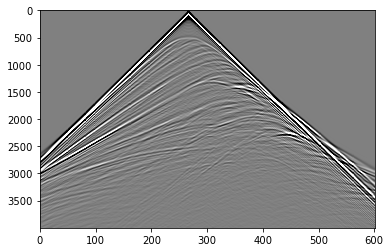

In [28]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,ns//2].cpu().numpy(), [2,98])

plt.imshow(data_true[:,ns//2,].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



## Create initial model for FWI 

### Task 1:  test different initial model (i.e. different smoothing) and observe the convergence. 

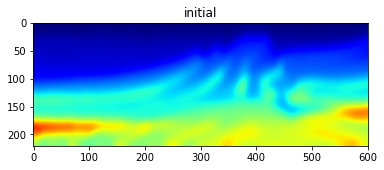

In [31]:
# Create initial guess model for inversion by smoothing the true model
model_init = # To do 

model_init = model_init * msk  # to preserve the water layer  
model_init[model_init==0] = 1.5 # km/s


model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

# plot the initial model 
plt.imshow(model_init, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('initial');

##  Set the optimizer and the criterion 

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = # To do 

## Filter the low frequencies from the observed data/wavelet   
(hint: you can use the below functions to filter the data or whatever function you want) 
The below functions are only applies for 1D which means you need to filter the data trace by trace (becarefule with the shapes).

In [ ]:
def butter_bandpass(lowcut, highcut, fs,btype ,order=7):
    nyq = 0.5 * fs
    if lowcut != None: low = lowcut / nyq
    if highcut != None: high = highcut / nyq

    if btype == 'band': b, a = signal.butter(order, [low, high], btype=btype, analog=False)
    if btype == 'low':  b, a = signal.butter(order, high, btype=btype, analog=False)
    if btype == 'high': b, a = signal.butter(order,low, btype=btype, analog=False)
    
    return b, a        

def butter_bandpass_filter(data,lowcut=None,highcut=None,fs=None,btype='band',order=7):
    """
    This functions create a butterworth filter and apply the bandpass/high_cut/low_cut filters to the data  

    Arguments:
    ----------
            data   :     1D array that will be filtered 
            lowcut :   The lower band of frequency  [None for law_pass_filter] 
            highcut:  The high band of frequency  [None for high_pass filter]
            btype  :  filtertype ['band','low','high']
            order  :  order of the butterworth filter 
    for more details - check the scipy documentation 
    """
    b, a = butter_bandpass(lowcut, highcut, fs,btype, order=order)
    y = signal.filtfilt(b, a, data)
    return y 



# To do: filter the wavelet and the data 
# 
#     


## Main inversion loop 

In [ ]:
# Iterative inversion loop
t_start = time.time()
num_shots_per_batch = int(ns / num_batches)
num_epochs = FWI_itr 
epoch_loss = []
for epoch in range(num_epochs):
  running_loss=0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    loss = criterion(data_pred, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)     

  # Apply some operations to the gradient
  if epoch==0: gmax = torch.abs(model.grad).max()
  model.grad = model.grad / gmax   # normalizing by the first gradient 


  # update the model 
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)
    
  # plotting every 10 itr   
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax,
               cmap='jet')
    plt.colorbar()
    
    plt.figure(figsize=(8, 4))
    plt.imshow(model.grad.cpu().detach().numpy(), 
               cmap='seismic',vmin=-0.05,vmax=0.05)
    plt.colorbar()
    plt.show()
    
t_end = time.time()
print('Runtime:', t_end - t_start)